In [1]:
import os
import sys
import pandas as pd  # noqa: F401
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# ============================================================
# ✅ Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/claudiatagbo/Masterschool/traveltide


In [2]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: core module found at: None


## **Pfad zum Speichern von PCA**

In [3]:
# Pfad für Feature-Metriken erstellen:
# Hier werden alle PCA-bezogenen Datensätze gespeichert (z. B. transformierte Daten).
pca_data_path = os.path.join(project_root, 'data', 'processed', 'kmean')

# Pfad für Visualisierungen (Plots, Heatmaps, Grafiken) zur PCA/KMeans-Analyse.
pca_fig_path = os.path.join(project_root, 'reports', 'viz', 'kmean')

#eda_data_path = os.path.join(project_root, 'reports', 'eda', 'results')
# Optionaler Pfad für EDA-Ergebnisse (aktuell deaktiviert).

# Ordner erstellen, falls sie noch nicht existieren.
# exist_ok=True verhindert Fehler, wenn die Ordner bereits vorhanden sind.
os.makedirs(pca_data_path, exist_ok=True)
os.makedirs(pca_fig_path, exist_ok=True)

#os.makedirs(eda_data_path, exist_ok=True)
# Optionaler EDA


## **Import Core Package** 

In [4]:
from core.load_data import load_table

:weißes_häkchen: Connected to PostgreSQL database.


## **Load PCA Components aus CVS**

In [5]:
df_pca = load_table(data_type='pca', table_name='user_pca')

 Lade Tabelle 'user_pca' aus CSV: /Users/claudiatagbo/Masterschool/traveltide/core/../data/processed/pca/user_pca.csv
 CSV geladen. Zeilen: 5998


In [6]:
def plot_elbow_silhouette(user_pca, k_min=2, k_max=10):
    """
    Generate a combined Elbow + Silhouette plot in one graph.

    Parameters
    ----------
    user_pca : array-like
        PCA-transformed feature matrix.
    k_min : int, default=2
        Minimum number of clusters to test (must be >=2 for silhouette).
    k_max : int, default=12
        Maximum number of clusters to test.

    Returns
    -------
    elbow_k : int
        Optimal number of clusters based on elbow method.
    silhouette_k : int
        Optimal number of clusters based on silhouette score.
    results : dict
        Dictionary with inertia and silhouette scores for each k.
    """
    range_n_clusters = range(k_min, k_max + 1)
    silhouette_scores = []
    inertia_values = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(user_pca)

        silhouette_avg = silhouette_score(user_pca, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        inertia_values.append(kmeans.inertia_)
        
    # Find elbow point (simple approach)
    diffs = np.diff(inertia_values)
    diff_ratios = diffs[:-1] / diffs[1:]
    elbow_k = np.argmax(diff_ratios) + k_min + 1  # adjust offset

    # Optimal K by silhouette
    silhouette_k = np.argmax(silhouette_scores) + k_min

    # Plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    ax1.plot(range_n_clusters, inertia_values, 'o-', color='steelblue', label="Inertia (Elbow)")
    ax2.plot(range_n_clusters, silhouette_scores, 's-', color='darkorange', label="Silhouette Score")

    ax1.set_xlabel("Number of Clusters (k)")
    ax1.set_ylabel("Inertia", color='steelblue')
    ax2.set_ylabel("Silhouette Score", color='darkorange')
    ax1.grid(True)

    # Mark optimal K with labels
    line1 = ax1.axvline(silhouette_k, color='red', linestyle='--', label="Silhouette Optimal K")
    line2 = ax2.axvline(elbow_k, color='black', linestyle='--', label="Elbow Optimal K")

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")

    plt.title("Elbow & Silhouette Analysis")
    save_path = os.path.join(pca_fig_path, "elbow_vs_silhouette.png")
    plt.savefig(save_path, dpi=300)
    fig.tight_layout()
    plt.show()

    print(f"🎯 Optimal number of clusters (Elbow): {elbow_k}")
    print(f"🎯 Optimal number of clusters (Silhouette): {silhouette_k}")

    results = {
        "inertia": dict(zip(range_n_clusters, inertia_values)),
        "silhouette": dict(zip(range_n_clusters, silhouette_scores))
    }

    return elbow_k, silhouette_k, results

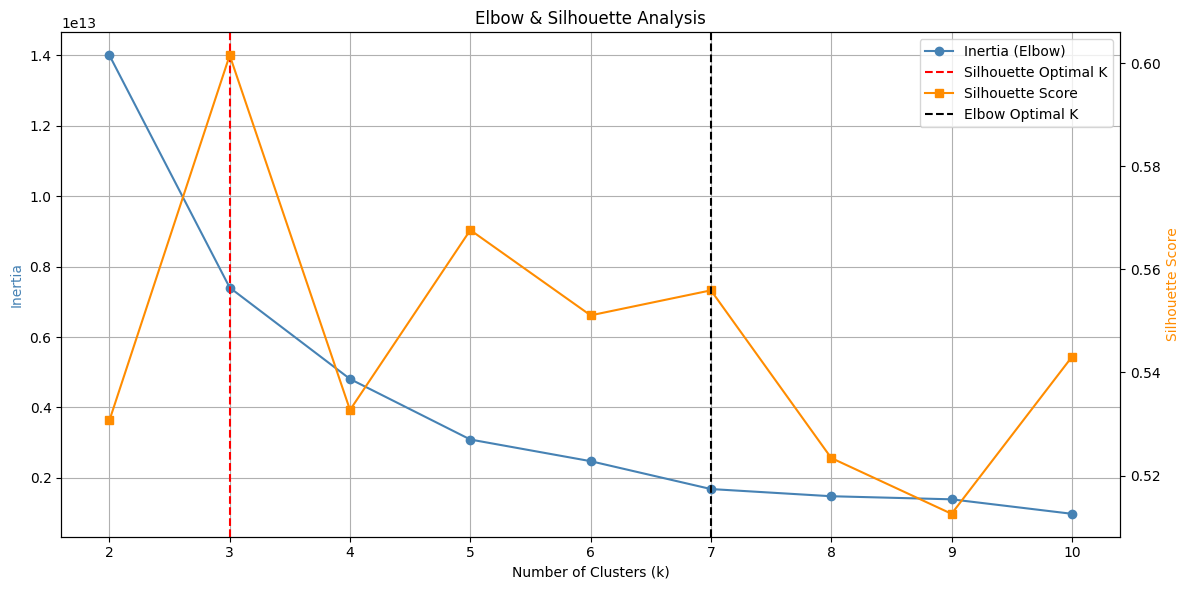

🎯 Optimal number of clusters (Elbow): 7
🎯 Optimal number of clusters (Silhouette): 3


In [7]:
elbow_k, silhouett_k , results = plot_elbow_silhouette(user_pca=df_pca)

**Elbow-Methode (7 Cluster):**

Diese Methode schlägt **7 Cluster** vor, weil sie feinere, detailliertere Gruppierungen in den Daten erkennt. Das deutet darauf hin, dass dein Datensatz eine **komplexe Struktur mit mehreren Untergruppen** haben könnte, die sich durch zusätzliche Cluster besser abbilden lassen.

**Silhouette-Score (3 Cluster):**

Der Silhouette-Score empfiehlt **3 Cluster**, da er bewertet, wie gut die Cluster voneinander getrennt sind. Eine kleinere Clusterzahl deutet darauf hin, dass **ab 4 oder mehr Clustern die Trennschärfe zwischen den Gruppen schlechter wird** und sich die Cluster weniger klar voneinander unterscheiden.


In [8]:
def run_kmeans_clustering(user_pca: pd.DataFrame, optimal_n_clusters: int, random_state: int = 42) -> pd.DataFrame:
    """
    Run K-Means clustering with the optimal number of clusters and assign group labels.
    Parameters
    ----------
    user_pca : pd.DataFrame
        PCA-transformed feature matrix (rows = users, columns = principal components).
    optimal_n_clusters : int
        Optimal number of clusters determined by elbow/silhouette analysis.
    random_state : int, default=42
        Random seed for reproducibility.
    Returns
    -------
    pd.DataFrame
        Input DataFrame with an additional 'group' column containing cluster assignments.
    """
    user_pca = user_pca.copy()  # avoid modifying original
    # Fit KMeans
    kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(user_pca)
    print(f":weißes_häkchen: K-Means clustering complete: {optimal_n_clusters} clusters assigned")
    return kmeans,cluster_labels




## **„Beide vorgeschlagenen Clusterzahlen ausprobieren“**

In [9]:
from sklearn.decomposition import PCA
def optimal_number_of_cluster_analyse(df:pd.DataFrame, optimal_k: int, results: dict):
    kmeans, cluster_labels = run_kmeans_clustering(user_pca=df, optimal_n_clusters=optimal_k)
    # Calculate Silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    db_score = davies_bouldin_score(df, cluster_labels)
    ch_score = calinski_harabasz_score(df, cluster_labels)
    inertia = kmeans.inertia_
    results[optimal_k] = {
            'silhouette': silhouette_avg,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score,
            'labels': cluster_labels,
            'centers': inertia,
            f'{optimal_k}_means': kmeans,
            f'{optimal_k}_labels': cluster_labels
    }
    print(f"For k={optimal_k}:")
    print(f"Silhouette Score = {silhouette_avg:.3f}")
    print(f"Davies.Bouldin Score = {db_score:.3f}")
    print(f"Calinski-Harabasz Score = {ch_score:.3f}")
    print(f"inertion = {inertia:.3f}")
    # Visualize Clusters
    if df_pca.shape[1] == 2:
            plt.figure(figsize=(10,8))
            plt.scatter(df[:,0],df_pca[:, 1], c=cluster_labels, cmap='viridis')
            plt.title(f'K-menas clustering with k={optimal_k}')
            save_path = os.path.join(pca_fig_path, f"{optimal_k}-means_cluster.png")
            plt.savefig(save_path, dpi=300)
            plt.show()
    else:
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(df)
            plt.figure(figsize=(10,8))
            plt.scatter(X_pca[:,0],X_pca[:, 1], c=cluster_labels, cmap='viridis')
            plt.title(f'K-menas clustering with k={optimal_k}')
            save_path = os.path.join(pca_fig_path, f"{optimal_k}-means_cluster.png")
            plt.savefig(save_path, dpi=300)
            plt.show()

    return results



:weißes_häkchen: K-Means clustering complete: 3 clusters assigned
For k=3:
Silhouette Score = 0.602
Davies.Bouldin Score = 0.562
Calinski-Harabasz Score = 7235.870
inertion = 7404489465218.982


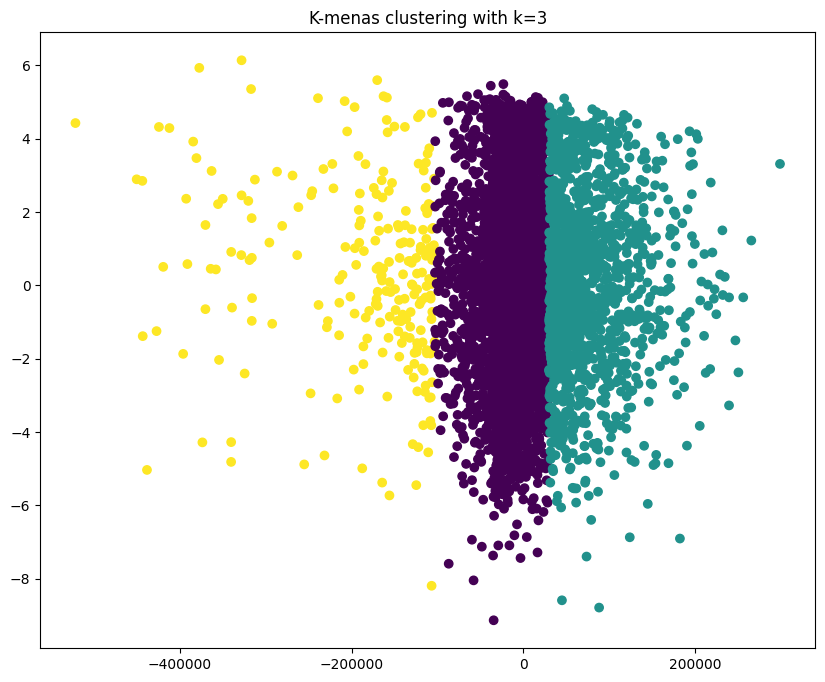

:weißes_häkchen: K-Means clustering complete: 7 clusters assigned
For k=7:
Silhouette Score = 0.556
Davies.Bouldin Score = 0.498
Calinski-Harabasz Score = 14018.001
inertion = 1680872347928.015


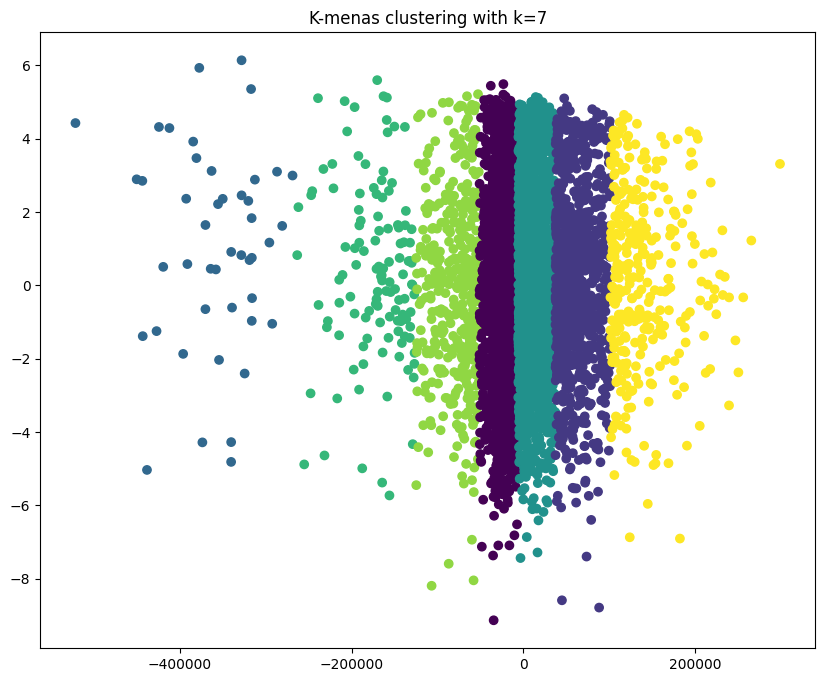

In [10]:
k_values = [3, 7]
results ={}
for optimal_k in k_values:
   optimal_number_of_cluster_analyse(df=df_pca, optimal_k=optimal_k, results=results)

## **Vergleich von beide Bilder**
**K=3 bietet bessere Cluster-Trennung (Silhouette Score 0.602)**, ist einfacher zu interpretieren und eignet sich ideal **für strategische Geschäftsentscheidungen**. 
**K=7 liefert feinere Kundensegmente mit überlegenen statistischen Metriken (3 von 4 besser)** und ist perfekt für detaillierte Marketing-Kampagnen.
Für einen ausgewogenen Ansatz **wäre K=5 als Kompromiss** zwischen Interpretierbarkeit und Detaillierungsgrad zu empfehlen.


:weißes_häkchen: K-Means clustering complete: 5 clusters assigned
For k=5:
Silhouette Score = 0.568
Davies.Bouldin Score = 0.496
Calinski-Harabasz Score = 10766.592
inertion = 3088021761714.263


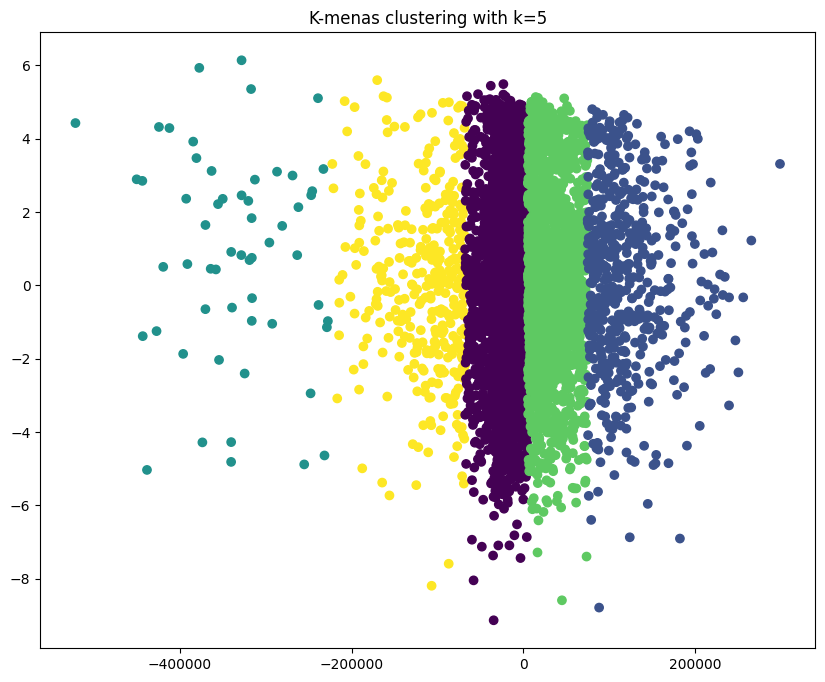

In [11]:
optimal_k_5 = 5
results = optimal_number_of_cluster_analyse(df=df_pca, optimal_k=optimal_k_5, results=results)

Für eine Balance aus Interpretierbarkeit und Detailtiefe stellt K = 5 den optimalen Mittelweg dar, da es klar definierte Cluster bietet und gleichzeitig genügend Nuancen für operative Use Cases liefert.

In [12]:
results[5]

{'silhouette': 0.567614682422072,
 'davies_bouldin': 0.49618396085801486,
 'calinski_harabasz': 10766.591843907076,
 'labels': array([2, 2, 2, ..., 1, 1, 1], shape=(5998,), dtype=int32),
 'centers': 3088021761714.2627,
 '5_means': KMeans(n_clusters=5, random_state=42),
 '5_labels': array([2, 2, 2, ..., 1, 1, 1], shape=(5998,), dtype=int32)}

In [13]:
df_pca['cluster_3']=results[3]['3_labels']
df_pca['cluster_5']=results[5]['5_labels']
df_pca['cluster_7']=results[7]['7_labels']

In [14]:
df_pca.columns

Index(['user_id', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',
       'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'cluster_3',
       'cluster_5', 'cluster_7'],
      dtype='object')

In [15]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"
def plot_clusters_2d(df:pd.DataFrame, optimal_n_clusters: int=3, cluster_name:str='cluster_3') -> None:
    """
    Plot clusters using the first two PCA components (2D scatter plot).
    Parameters
    ----------
    user_pca : pd.DataFrame
        PCA-transformed data with a 'group' column containing cluster labels.
    optimal_n_clusters : int
        Number of clusters used in K-Means.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df.iloc[:, 0],  # PC1
        df.iloc[:, 1],  # PC2
        c=df[cluster_name],
        cmap='viridis',
        s=50,
        alpha=0.7
    )
    plt.title(f'K-Means Clustering mit {optimal_n_clusters} Clustern (2D PCA)')
    plt.xlabel('PCA Komponente 1')
    plt.ylabel('PCA Komponente 2')
    plt.grid(True)
    # Legend for cluster groups
    plt.legend(*scatter.legend_elements(), title='Gruppe')
    save_path = os.path.join(pca_fig_path, f"{optimal_n_clusters}-means_{cluster_name}_2d.png")
    plt.savefig(save_path, dpi=300)
    plt.tight_layout()
    plt.show()






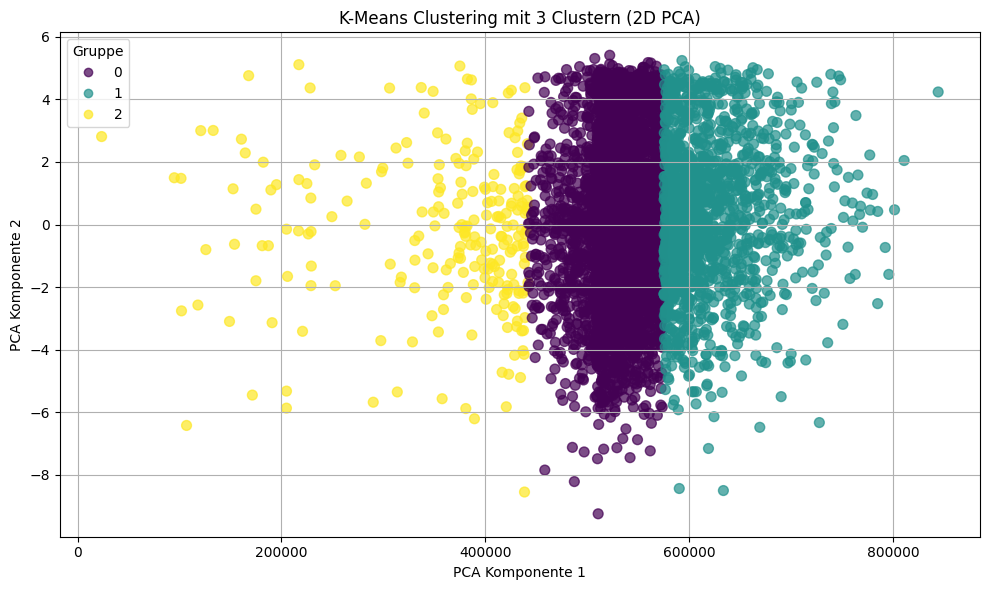

In [16]:
plot_clusters_2d(df=df_pca)

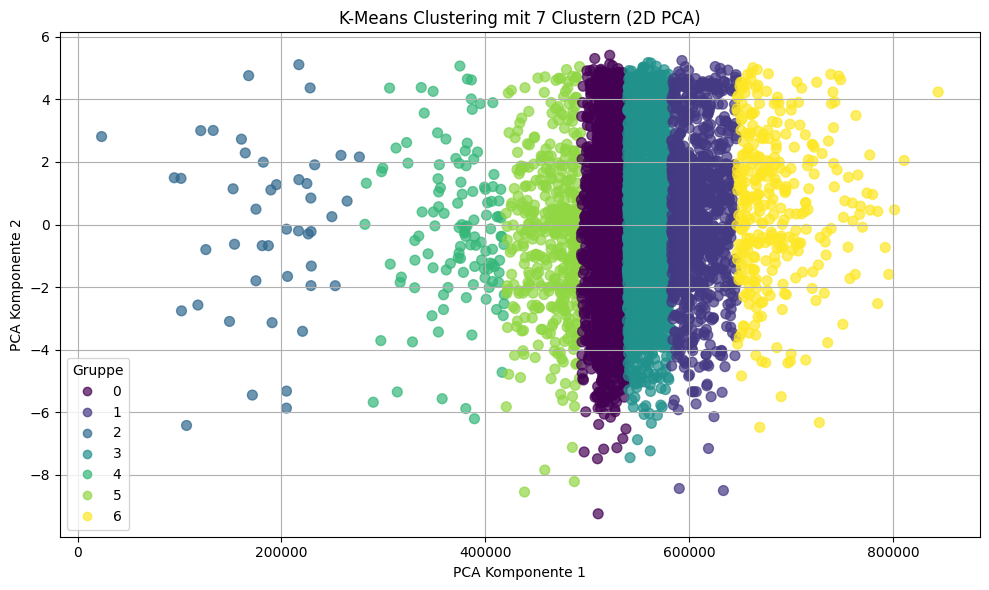

In [20]:
plot_clusters_2d(df_pca, optimal_n_clusters=7, cluster_name='cluster_7')

In [17]:
def plot_clusters_3d(df: pd.DataFrame, optimal_n_clusters: int = 3, cluster_name: str='cluster_3'):
    """
    Plot clusters using the first three PCA components (3D scatter plot).
    """
    fig = px.scatter_3d(
        df,
        x=df.columns[0],
        y=df.columns[1],
        z=df.columns[2],
        color='cluster_5',
        title=f'K-Means Clustering with {optimal_n_clusters} Clusters (3D PCA)',
        labels={
            df.columns[0]: "PCA Component 1",
            df.columns[1]: "PCA Component 2",
            df.columns[2]: "PCA Component 3"
        }
    )
    fig.update_traces(marker=dict(size=5, opacity=0.7))
    # Ensure directory exists
    path = os.path.join(pca_fig_path, 'html')
    os.makedirs(path, exist_ok=True)
    # Use a safe filename
    save_path = os.path.join(path, f'{optimal_n_clusters}-means_{cluster_name}3d.html')
    fig.show()
    fig.write_html(save_path)
    print(f"3D cluster plot saved to {save_path}")





In [18]:
plot_clusters_3d(df=df_pca,optimal_n_clusters=7, cluster_name='cluster_7')

3D cluster plot saved to /Users/claudiatagbo/Masterschool/traveltide/reports/viz/kmean/html/7-means_cluster_73d.html


In [19]:
save_csv_path = os.path.join(pca_data_path, "user_segment.csv")
df_pca.to_csv(save_csv_path, index=False)